In [1]:
# import the necessary packages
from __future__ import print_function
from scipy.spatial import distance as dist
from prettytable import PrettyTable
from imutils import perspective
from imutils import contours
import numpy as np
import pandas as pd
import argparse
import imutils
import cv2

width = 26 #standard width of 2 rupee coin
pixelsPerMetric = None

def midpoint(ptA, ptB):
	return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

def order_points_old(pts):
    # initialize a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

# load our input image, convert it to grayscale, and blur it slightly
image = cv2.imread(r"C:\Users\ablaz\Downloads\ceeri_5.jpg")
#windows = cv2.namedWindow('image',cv2.WINDOW_NORMAL)
resize = cv2.resize(image, (900,864))
gray = cv2.cvtColor(resize, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)

# perform edge detection, then perform a dilation + erosion to
# close gaps in between object edges
edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

#cv2.imshow("edged",edged)

# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# sort the contours from left-to-right and initialize the bounding box
# point colors
(cnts, _) = contours.sort_contours(cnts)
colors = ((0, 0, 255), (240, 0, 159), (255, 0, 0), (255, 255, 0))

# loop over the contours individually
for (i, c) in enumerate(cnts):
    # if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 500:
        continue

    # compute the rotated bounding box of the contour, then
    # draw the contours
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    cv2.drawContours(resize, [box], -1, (0, 255, 0), 2)

    # show the original coordinates
    print("Object #{}:".format(i + 1))
    print(box)

    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    rect = perspective.order_points(box)

    # show the re-ordered coordinates
    print(rect.astype("int"))
    print("")
    cv2.drawContours(resize, [box.astype("int")], -1, (0, 255, 0), 2)

    # loop over the original points and draw them
    for (x, y) in box:
        cv2.circle(resize, (int(x), int(y)), 5, (0, 0, 255), -1)

    # unpack the ordered bounding box, then compute the midpoint
    # between the top-left and top-right coordinates, followed by
    # the midpoint between bottom-left and bottom-right coordinates
    (tl, tr, br, bl) = box
    (tltrX, tltrY) = midpoint(tl, tr)
    (blbrX, blbrY) = midpoint(bl, br)

    # compute the midpoint between the top-left and top-right points,
    # followed by the midpoint between the top-righ and bottom-right
    (tlblX, tlblY) = midpoint(tl, bl)
    (trbrX, trbrY) = midpoint(tr, br)

    # draw the midpoints on the image
    cv2.circle(resize, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(resize, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    cv2.circle(resize, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    cv2.circle(resize, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)

    # draw lines between the midpoints
    cv2.line(resize, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
        (255, 0, 255), 2)
    cv2.line(resize, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
        (255, 0, 255), 2)

    # compute the Euclidean distance between the midpoints
    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))

    # if the pixels per metric has not been initialized, then
    # compute it as the ratio of pixels to supplied metric
    # (in this case, mm)
    if pixelsPerMetric is None:
        pixelsPerMetric = dB / width

    # compute the size of the object
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric

    # loop over the original points and draw them
    for ((x, y), color) in zip(rect, colors):
        cv2.circle(resize, (int(x), int(y)), 5, color, -1)

    # draw the object num at the top-left corner
    cv2.putText(resize, "Object #{}".format(i + 1),
        (int(rect[0][0] - 15), int(rect[0][1] - 15)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 255, 255), 2)
    
    # draw the object sizes on the image
    cv2.putText(resize, "{:.1f}mm".format(dimA),
        (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
        0.65, (255, 255, 255), 2)
    cv2.putText(resize, "{:.1f}mm".format(dimB),
        (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
        0.65, (255, 255, 255), 2)
    
    # show the image
    cv2.imshow("Image", resize)
    cv2.waitKey(0)

ModuleNotFoundError: No module named 'prettytable'

# Gaussian Blur

Gaussian blur (also known as Gaussian smoothing) is the result of blurring an image by a Gaussian function.

$ G(x,y)={\frac {1}{2\pi \sigma ^{2}}}e^{-{\frac {x^{2}+y^{2}}{2\sigma ^{2}}}} $

where x is the distance from the origin in the horizontal axis, y is the distance from the origin in the vertical axis, and σ is the standard deviation of the Gaussian distribution. When applied in two dimensions, this formula produces a surface whose contours are concentric circles with a Gaussian distribution from the center point.


# Canny Edge Detection
https://docs.opencv.org/trunk/da/d22/tutorial_py_canny.html


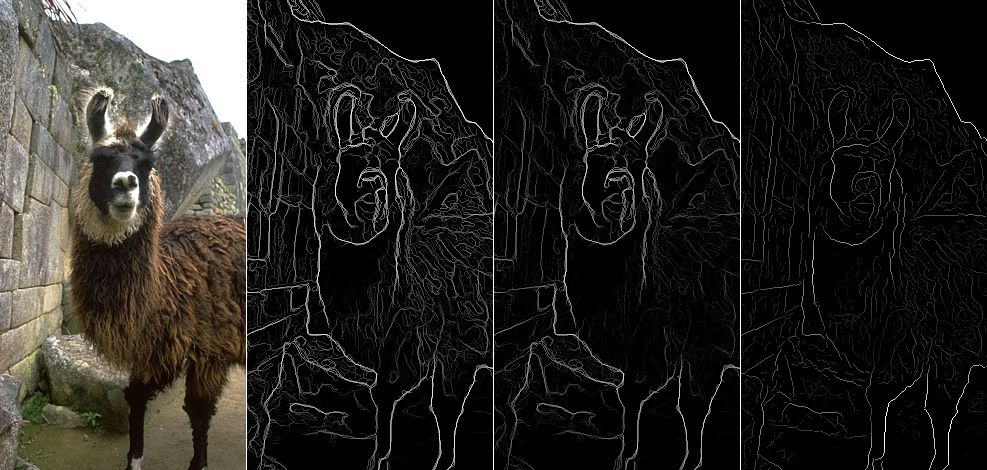


Canny edge detection is a multi-step algorithm that can detect edges with noise supressed at the same time.

1. Smooth the image with a Gaussian filter to reduce noise and unwanted details and textures.
$$g(m,n)=G_{\sigma}(m,n)*f(m,n)$$

where
$$G_{\sigma}=\frac{1}{\sqrt{2\pi\sigma^2}}exp\left(-\frac{m^2+n^2}{2\sigma^2}\right)$$

2. Compute gradient of $g(m,n)$ using any of the gradient operatiors (Roberts, Sobel, Prewitt, etc) to get:
$$M(n,n)=\sqrt{g_m^2(m,n)+g_n^2(m,n)}$$

and
$$\theta(m,n)=tan^{-1}[g_n(m,n)/g_m(m,n)]$$

3. Threshold M:
$$
M_T(m,n)=\left\{ \begin{array}{ll}
M(m,n) & \mbox{if $M(m,n)>T$}  0 & \mbox{otherwise}
\end{array} \right.
$$

where $T$ is so chosen that all edge elements are kept while most of the noise is suppressed.

4. Suppress non-maxima pixels in the edges in $M_T$ obtained above to thin the edge ridges (as the edges might have been broadened in step 1). To do so, check to see whether each non-zero $M_T(m,n)$ is greater than its two neighbors along the gradient direction $\theta(m,n)$. If so, keep $M_T(m,n)$ unchanged, otherwise, set it to 0.

5. Threshold the previous result by two different thresholds $\tau_1$ and $\tau_2$ (where $\tau_1<\tau_2$) to obtain two binary images $T_1$ and $T_2$. Note that $T_2$ with greater $\tau_2$ has less noise and fewer false edges but greater gaps between edge segments, when compared to $T_1$ with smaller $\tau_1$.

6. Link edge segments in $T_2$ to form continuous edges. To do so, trace each segment in $T_2$ to its end and then search its neighbors in $T_1$ to find any edge segment in $T_1$ to bridge the gap untill reaching another edge segment in $T_2$.

# For Reference:
<br>
Object 1: 2 Rupee Coin
<br>
Object 2: Visiting Card 
<br>
Object 3: Passport Photo 
<br>
Object 4: Sticky Note 
<br>
Object 5: Playing Card 
<br>
Object 6: ATM Card 
<br>

Error = ( | Dimension Obtained – Actual Dimension | ) / Actual Dimension

In [12]:
x = PrettyTable()

x.add_column("Image", [1,1,1,1,1,2,2,2,2,2,3,3,3,3,4,4,4,4,4,5,5,5,5])
x.add_column("Object", [1,2,4,3,5,1,2,3,6,4,1,2,4,3,1,4,6,3,1,1,2,6,3])
x.add_column("Width(Predicted)", [26,87.1,79.9,34.5,52,26,87.9,36.1,78.7,82.6,26,91.4,83.8,35.3,26,78,86.7,35.5,26.5,26,88.4,85.2,33.9])
x.add_column("Height(Predicted)", [18.7,36.9,52.9,32,71.5,19.9,36.7,33.6,34.5,55.8,19,37.9,55.4,31.9,19.2,54.4,39.7,32.6,18.7,18.6,36.4,39.7,31])
x.add_column("Width(Actual)", [26,91.5,75,45,63.5,26,91.5,45,85.6,75,26,91.5,75,45,26,75,85.6,45,26,26,91.5,85.6,45])
x.add_column("Height(Actual)", [26,53.5,75,35,88.9,26,53.5,35,53.9,75,26,53.5,75,35,26,75,53.9,35,26,26,53.5,53.9,35])
x.add_column("Error(Width)", [0,-4.4,4.9,-10.5,-11.5,0,-3.6,-8.9,-6.9,7.6,0,-0.1,8.8,-9.7,0,3,1.1,-9.5,0.5,0,-3.1,-0.4,-11.1])
x.add_column("Error(Height)", [-7.3,-16.6,-22.1,-3,-17.4,-6.1,-16.8,-1.4,-19.4,-19.2,-7,-15.6,-19.6,-3.1,-6.8,-20.6,-14.2,-2.4,-7.3,-7.4,-17.1,-14.2,-4])

In [13]:
print(x)

+-------+--------+------------------+-------------------+---------------+----------------+---------------+----------------+
| Image | Object | Width(Predicted) | Height(Predicted) | Width(Actual) | Height(Actual) | Errors(Width) | Errors(Height) |
+-------+--------+------------------+-------------------+---------------+----------------+---------------+----------------+
|   1   |   1    |        26        |        18.7       |       26      |       26       |       0       |      -7.3      |
|   1   |   2    |       87.1       |        36.9       |      91.5     |      53.5      |      -4.4     |     -16.6      |
|   1   |   4    |       79.9       |        52.9       |       75      |       75       |      4.9      |     -22.1      |
|   1   |   3    |       34.5       |         32        |       45      |       35       |     -10.5     |       -3       |
|   1   |   5    |        52        |        71.5       |      63.5     |      88.9      |     -11.5     |     -17.4      |
|   2   

In [15]:
y = PrettyTable()

y.add_column("Abs(Error(Width))/Width(Actual)", [0,0.048087432,0.065333333,0.233333333,0.181102362,0,0.039344262,0.197777778,0.080607477,0.101333333,0,0.001092896,0.117333333,0.215555556,0,0.04,0.012850467,0.211111111,0.019230769,0,0.033879781,0.004672897,0.246666667])
y.add_column("Abs(Error(Height))/Height(Actual)", [0.280769231,0.310280374,0.294666667,0.085714286,0.195725534,0.234615385,0.314018692,0.04,0.359925788,0.256,0.269230769,0.291588785,0.261333333,0.088571429,0.261538462,0.274666667,0.263450835,0.068571429,0.280769231,0.284615385,0.319626168,0.263450835,0.114285714])

print(y)

+---------------------------------+-----------------------------------+
| Abs(Error(Width))/Width(Actual) | Abs(Error(Height))/Height(Actual) |
+---------------------------------+-----------------------------------+
|                0                |            0.280769231            |
|           0.048087432           |            0.310280374            |
|           0.065333333           |            0.294666667            |
|           0.233333333           |            0.085714286            |
|           0.181102362           |            0.195725534            |
|                0                |            0.234615385            |
|           0.039344262           |            0.314018692            |
|           0.197777778           |                0.04               |
|           0.080607477           |            0.359925788            |
|           0.101333333           |               0.256               |
|                0                |            0.269230769      

In [16]:
z = PrettyTable()

z.add_column("Avg. Error in Width", [0.080404904])
z.add_column("Avg. Error in Height", [0.235365869])
z.add_column("Avg. Error", [0.157885387])
z.add_column("Avg. Accuracy", [0.842114613])

print(z)

+---------------------+----------------------+-------------+---------------+
| Avg. Error in Width | Avg. Error in Height |  Avg. Error | Avg. Accuracy |
+---------------------+----------------------+-------------+---------------+
|     0.080404904     |     0.235365869      | 0.157885387 |  0.842114613  |
+---------------------+----------------------+-------------+---------------+
